In [1]:
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import collections
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.decomposition import PCA
np.random.seed(42)



In [2]:
# Cases from the 9th circuit court of appeals

df=pd.read_pickle('./assets/processed_text')

In [3]:
# Cases from appellate jurisdictions other than 9th

df2=pd.read_pickle('./assets/dc_processed_text')

In [4]:
def threshold_predict(model, threshold, inputvals):
    return [1 if item[1]>threshold else 0 for item in model.predict_proba(inputvals)]

In [5]:
def score_model (model, modelname, threshold, Xvals, yvals):
    
    y_predict=threshold_predict(model, threshold, Xvals)
    
    conf=confusion_matrix(yvals, y_predict)
    
    print ("Specificity", conf[0][0]/(conf[0][1]+conf[0][0]))
    
    print ("Sensitivity", conf[1][1]/(conf[1][0]+conf[1][1]))
    
    print ("Accuracy", (conf[1][1]+conf[0][0])/(conf[1][1]+conf[0][0]+conf[1][0]+conf[0][1]))
    

# A. Label cases based on whether from the 9th circuit's jurisdiction (1) or outside the 9th circuit (0)

In [6]:
# 9th circuit cases are "Positive"

df['label']=1

In [7]:
df2['label']=0

In [8]:
df.shape

(247, 42)

In [9]:
df2.shape

(205, 42)

In [10]:
combined=pd.concat([df, df2])

In [11]:
combined['label'].value_counts()

1    247
0    205
Name: label, dtype: int64

In [12]:
# To avoid give-aways about which circuit we're in, from the heading of the case, 
# trim the first 500 words away from each case

combined['text3']=combined['text2'].map(lambda x: x[500:])

In [13]:
# To avoid give-aways about which circuit we're in, from the ending of the case, 
# trim the last 500 words away from each case

combined['text3']=combined['text3'].map(lambda x: x[:-500])

In [14]:
train, test = train_test_split(combined,
                               stratify=combined['label'], random_state=42)

In [15]:
train['label'].value_counts()

1    185
0    154
Name: label, dtype: int64

In [16]:
test['label'].value_counts()

1    62
0    51
Name: label, dtype: int64

# B. Generate Feature Embeddings for Each Case Using Doc2Vec

In [17]:
def make_tagged_document(row):
    return TaggedDocument(words=row['text2'],
                          tags=[row['label']])

In [18]:
    

tagged_train_data=train.apply(lambda row: make_tagged_document(row), axis=1)

In [19]:
tagged_test_data=test.apply(lambda row: make_tagged_document(row), axis=1)

In [20]:


model = Doc2Vec(vector_size=100,  
                min_count=20,
                epochs=20,
               workers=1)



In [21]:


model.build_vocab(tagged_train_data)



In [22]:

model.train(tagged_train_data,
           total_examples=model.corpus_count,
           epochs=model.epochs)



In [23]:
model.docvecs.count

2

In [24]:
# Infer Vector Methods Adapted from https://fzr72725.github.io/2018/01/14/genism-guide.html

y_train=np.array([doc.tags[0] for doc in tagged_train_data])

y_test=np.array([doc.tags[0] for doc in tagged_test_data])

X_train=[model.infer_vector(doc.words, steps=20) for doc in tagged_train_data]

X_test=[model.infer_vector(doc.words, steps=20) for doc in tagged_test_data]

X_train=np.vstack(X_train)

X_test=np.vstack(X_test)

In [25]:
X_test.shape

(113, 100)

In [26]:
y_test.shape

(113,)

In [27]:
X_train.shape

(339, 100)

In [28]:
y_train.shape

(339,)

In [29]:
# Nearly all of the time, an inferred document vector is most similar
# to the document vector in the Doc2Vec model that matches its label

correct=0

for index in range(X_train.shape[0]):
    similar=model.docvecs.most_similar([X_train[index]])[0][0]
    if similar == y_train[index]:
        correct += 1

print (correct/X_train.shape[0])

0.9911504424778761


# C. Logistic Model to Sort Out Both Categories of Cases

In [30]:
pipeline1 = Pipeline([
    
    ('ss', StandardScaler()),
    ('lm', LogisticRegression())
])

In [31]:
hyperparameters={
                'lm__C': [0.00001, 0.0001, 0.001],
                'lm__penalty': ['l1', 'l2']
}

In [32]:
                
lingrid = GridSearchCV(pipeline1, hyperparameters, cv=3)

In [33]:
_=lingrid.fit(X_train, y_train)

In [34]:
lingrid.best_params_

{'lm__C': 0.001, 'lm__penalty': 'l2'}

In [35]:
lingrid.score(X_train, y_train)

0.9911504424778761

In [36]:
lingrid.score(X_test, y_test)

0.9380530973451328

In [37]:
roc_auc_score(y_test, lingrid.predict(X_test))

0.9400695762175839

In [38]:
roc_auc_score(y_train, lingrid.predict(X_train))

0.9913478413478414

In [39]:
confusion_matrix(y_test, lingrid.predict(X_test))

array([[49,  2],
       [ 5, 57]])

In [40]:
score_model(lingrid, "Linear Regression", .5, X_test, y_test)

Specificity 0.9607843137254902
Sensitivity 0.9193548387096774
Accuracy 0.9380530973451328


# D. Support Vector Machine

In [41]:
pipeline3 = Pipeline([
    
    ('ss', StandardScaler()),
    ('sv', svm.SVC())
])



In [42]:
hyperparameters={
            'sv__C':np.logspace(-4, 2, 3) ,   
            'sv__gamma': np.logspace(-8, 2, 8),
            'sv__probability': [True]
}
                
svcgrid = GridSearchCV(pipeline3, hyperparameters, cv=3)

In [43]:
svcgrid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sv', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'sv__C': array([1.e-04, 1.e-01, 1.e+02]), 'sv__gamma': array([1.00000e-08, 2.68270e-07, 7.19686e-06, 1.93070e-04, 5.17947e-03,
       1.38950e-01, 3.72759e+00, 1.00000e+02]), 'sv__probability': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [44]:
svcgrid.best_params_

{'sv__C': 100.0, 'sv__gamma': 7.196856730011529e-06, 'sv__probability': True}

In [45]:
svcgrid.score(X_train, y_train)

0.9911504424778761

In [46]:
svcgrid.score(X_test, y_test)

0.9203539823008849

In [47]:
roc_auc_score(y_test, svcgrid.predict(X_test))

0.9152435167615434

In [48]:
roc_auc_score(y_train, svcgrid.predict(X_train))

0.9902597402597403

In [49]:
confusion_matrix(y_test, svcgrid.predict(X_test))

array([[44,  7],
       [ 2, 60]])

In [50]:
score_model(svcgrid, "Support Vector Classifier", .5, X_test, y_test)

Specificity 0.9215686274509803
Sensitivity 0.9354838709677419
Accuracy 0.9292035398230089


# E.  PCA reduction to 2 dimensions

In [51]:
# Method adapted from https://github.com/sdimi/average-word2vec/blob/master/avg_word2vec_from_documents.py

In [52]:
ss=StandardScaler()
pca=PCA(n_components=2)

In [53]:
X_train_std=ss.fit_transform(X_train)
X_test_std=ss.fit_transform(X_test)

In [54]:
X_train_std_flat=pca.fit_transform(X_train_std)
X_test_std_flat=pca.fit_transform(X_test_std)

In [55]:
X_train_std_flat.shape

(339, 2)

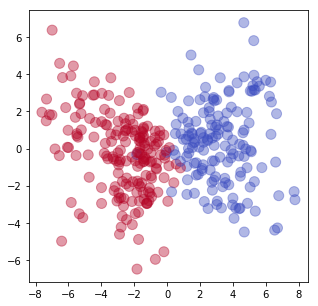

In [56]:
plt.figure(1, figsize=(5, 5))
plt.scatter(X_train_std_flat[:, 0], X_train_std_flat[:, 1],s=100, c=y_train, alpha=0.4, cmap="coolwarm")
plt.savefig('./assets/training_set')

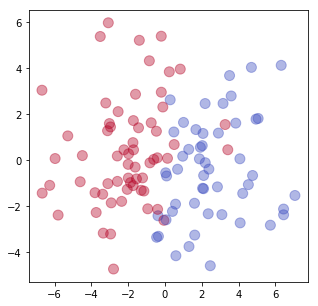

In [57]:
plt.figure(1, figsize=(5, 5))
plt.scatter(X_test_std_flat[:, 0], X_test_std_flat[:, 1],s=100, c=y_test, alpha=.4, cmap="coolwarm")
plt.savefig('./assets/test_set')

# G. Now Generate Flipped Feature Embeddings for Each Case Using Doc2Vec

In [58]:
def make_flipped_tagged_document(row):
    return TaggedDocument(words=row['text2'],
                          tags=[1-row['label']])

In [59]:
    

flipped_tagged_train_data=train.apply(lambda row: make_flipped_tagged_document(row), axis=1)

In [60]:

flipped_model = Doc2Vec(vector_size=100,  
                min_count=20,
                epochs=20,
               workers=1)

In [61]:

flipped_model.build_vocab(flipped_tagged_train_data)


In [62]:

flipped_model.train(flipped_tagged_train_data,
           total_examples=flipped_model.corpus_count,
           epochs=flipped_model.epochs)


In [63]:
flipped_model.docvecs.count

2

In [64]:
# Now infer vectors for the properly labeled data, using a network that is initalized with 
# the flipped data (i.e., network trained on mislabeled data)

y_train_f=np.array([doc.tags[0] for doc in tagged_train_data])

y_test_f=np.array([doc.tags[0] for doc in tagged_test_data])

X_train_f=[flipped_model.infer_vector(doc.words, steps=20) for doc in tagged_train_data]

X_test_f=[flipped_model.infer_vector(doc.words, steps=20) for doc in tagged_test_data]

X_train_f=np.vstack(X_train_f)

X_test_f=np.vstack(X_test_f)

In [65]:
X_test_f.shape

(113, 100)

In [66]:
y_test_f.shape

(113,)

In [67]:
X_train_f.shape

(339, 100)

In [68]:
y_train_f.shape

(339,)

In [69]:
# In almost every case an inferred document vector is most similar
# to the wrong category, i.e., the document vector in the Doc2Vec model
# that does not match its category.

correct=0

for index in range(X_train_f.shape[0]):
    similar=flipped_model.docvecs.most_similar([X_train_f[index]])[0][0]
    if similar == y_train_f[index]:
        correct += 1

print (correct/X_train_f.shape[0])

0.008849557522123894


# H. Logistic Model to Sort Out Both Categories of Cases, Based on Flipped Data

In [70]:
pipeline1 = Pipeline([
    
    ('ss', StandardScaler()),
    ('lm', LogisticRegression())
])

In [71]:
hyperparameters={
                'lm__C': [0.00001, 0.0001, 0.001],
                'lm__penalty': ['l1', 'l2']
}

In [72]:
                
lingrid = GridSearchCV(pipeline1, hyperparameters, cv=3)

In [73]:
_=lingrid.fit(X_train_f, y_train_f)

In [74]:
lingrid.best_params_

{'lm__C': 0.001, 'lm__penalty': 'l2'}

In [75]:
lingrid.score(X_train_f, y_train_f)

0.9911504424778761

In [76]:
lingrid.score(X_test_f, y_test_f)

0.9292035398230089

In [77]:
roc_auc_score(y_test_f, lingrid.predict(X_test_f))

0.9320050600885517

In [78]:
roc_auc_score(y_train_f, lingrid.predict(X_train_f))

0.9913478413478414

In [79]:
confusion_matrix(y_test_f, lingrid.predict(X_test_f))

array([[49,  2],
       [ 6, 56]])

In [80]:
score_model(lingrid, "Linear Regression", .5, X_test_f, y_test_f)

Specificity 0.9607843137254902
Sensitivity 0.9032258064516129
Accuracy 0.9292035398230089


# I. Support Vector Machine, Based on Flipped Data

In [81]:
pipeline3 = Pipeline([
    
    ('ss', StandardScaler()),
    ('sv', svm.SVC())
])



In [82]:
hyperparameters={
            'sv__C':np.logspace(-4, 2, 3) ,   
            'sv__gamma': np.logspace(-8, 2, 8),
            'sv__probability': [True]
}
                
svcgrid = GridSearchCV(pipeline3, hyperparameters, cv=3)

In [83]:
svcgrid.fit(X_train_f, y_train_f)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sv', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'sv__C': array([1.e-04, 1.e-01, 1.e+02]), 'sv__gamma': array([1.00000e-08, 2.68270e-07, 7.19686e-06, 1.93070e-04, 5.17947e-03,
       1.38950e-01, 3.72759e+00, 1.00000e+02]), 'sv__probability': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [84]:
svcgrid.best_params_

{'sv__C': 100.0, 'sv__gamma': 7.196856730011529e-06, 'sv__probability': True}

In [85]:
svcgrid.score(X_train_f, y_train_f)

0.9970501474926253

In [86]:
svcgrid.score(X_test_f, y_test_f)

0.9292035398230089

In [87]:
roc_auc_score(y_test_f, svcgrid.predict(X_test_f))

0.9285262492093613

In [88]:
roc_auc_score(y_train_f, svcgrid.predict(X_train_f))

0.9967532467532468

In [89]:
confusion_matrix(y_test_f, svcgrid.predict(X_test_f))

array([[47,  4],
       [ 4, 58]])

In [90]:
score_model(svcgrid, "Support Vector Classifier", .5, X_test_f, y_test_f)

Specificity 0.9411764705882353
Sensitivity 0.9032258064516129
Accuracy 0.9203539823008849


# J.  PCA reduction to 2 dimensions, based on flipped data

In [91]:
# Method adapted from https://github.com/sdimi/average-word2vec/blob/master/avg_word2vec_from_documents.py

In [92]:
ss=StandardScaler()
pca=PCA(n_components=2)

In [93]:
X_train_f_std=ss.fit_transform(X_train_f)
X_test_f_std=ss.fit_transform(X_test_f)

In [94]:
X_train_f_std_flat=pca.fit_transform(X_train_f_std)
X_test_f_std_flat=pca.fit_transform(X_test_f_std)

In [95]:
X_train_f_std_flat.shape

(339, 2)

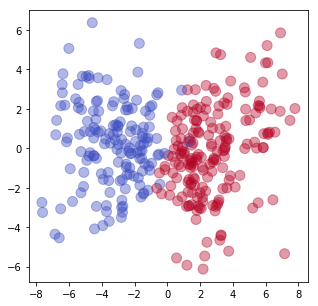

In [96]:
plt.figure(1, figsize=(5, 5))
plt.scatter(X_train_f_std_flat[:, 0], X_train_f_std_flat[:, 1],s=100, c=y_train_f, alpha=0.4, cmap="coolwarm")


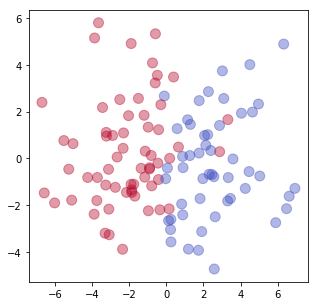

In [97]:
plt.figure(1, figsize=(5, 5))
plt.scatter(X_test_f_std_flat[:, 0], X_test_f_std_flat[:, 1],s=100, c=y_test_f, alpha=.4, cmap="coolwarm")
